# Generation of λ-Nets for I-Net training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'function_family': {
        'maximum_depth': 3,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,          
        'dt_type': 'vanilla', #'vanilla', 'SDT'
    },
    'data': {
        'number_of_variables': 10, 
        'num_classes': 2,
        'categorical_indices': [],
        'random_parameters_distribution': True, ##MAKEPATH DIFFERENT FILES
        'max_distributions_per_class': 1, # None; 0; int >= 1
        'exclude_linearly_seperable': True,
        'data_generation_filtering': True,
        'fixed_class_probability': False,
        'weighted_data_generation': False,
        'shift_distrib': False,
        
        'function_generation_type': 'distribution' ,#'distribution', 'distribution_trained' 'make_classification_distribution', 'make_classification_distribution_trained', 'make_classification', 'make_classification_trained', 'random_decision_tree', 'random_decision_tree_trained'
        'distribution_list': ['uniform', 'gamma', 'poisson', 'exponential', 'weibull'],#['uniform', 'normal', 'gamma', 'beta', 'poisson', 'lognormal', 'exponential', 'f', 'logistic', 'weibull'],#['uniform', 'normal', 'gamma', 'exponential', 'beta', 'binomial', 'poisson'], 
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 5000, #number of samples per function
        'number_of_generated_datasets': 10000,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
        
        'data_noise': 0, #None or float
        'distrib_param_max': 5,
    }, 
    'lambda_net': {
        'epochs_lambda': 1000,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-3,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [128],
        'use_batchnorm_lambda': False,
        
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
                
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 10000,
    },     
    'evaluation': {   
    },    
    
    'computation':{
        'n_jobs': 25,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}




In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from itertools import product       # forms cartesian products
from tqdm import tqdm_notebook as tqdm
from more_itertools import random_product 
import pickle
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt 
import time
import math
import operator
from functools import reduce

from scipy.signal import argrelextrema

import sys

import shutil

import logging
logging.getLogger('tensorflow').disabled = True

from joblib import Parallel, delayed


from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
#from similaritymeasures import frechet_dist, area_between_two_curves, dtw
from IPython.display import Image

from livelossplot import PlotLossesKerasTF

import seaborn as sns

import tensorflow as tf
#import tensorflow_addons as tfa
import random 


#import keras
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



In [4]:
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################
    
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' if use_gpu else ''

#os.environ['XLA_FLAGS'] =  '--xla_gpu_cuda_data_dir=/usr/local/cuda-10.1'

#os.environ['XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
#os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda-11.4' if use_gpu else ''#-10.1' #--xla_gpu_cuda_data_dir=/usr/local/cuda, 
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2 ,--tf_xla_enable_xla_devices' if use_gpu else ''#'--tf_xla_auto_jit=2' #, --tf_xla_enable_xla_devices


sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)

In [5]:
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(config)
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)

#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='lambda_net'))
generate_directory_structure()
generate_lambda_net_directory(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

0it [00:00, ?it/s]

In [6]:
print(path_identifier_lambda_net_data)

print(path_identifier_function_data)


lNetSize5000_numLNets10000_var10_class2_distribution_xMax1_xMin0_xDistuniform_dNoise0_randParamDist_maxDistClass1_distribParamMax5_randClassProb_filterGenun-ga-po-ex-we_depth3_beta1_decisionSpars1_vanilla_fullyGrown/128_e1000ES0.001_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42
lNetSize5000_numDatasets10000_var10_class2_distribution_xMax1_xMin0_xDistuniform_dNoise0_randParamDist_maxDistClass1_distribParamMax5_randClassProb_filterGenun-ga-po-ex-we_depth3_beta1_decisionSpars1_vanilla_fullyGrown


In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


In [8]:
lambda_network_layers

[128]

In [9]:
path_functions = './data/saved_function_lists/functions_' + path_identifier_function_data + '.csv'
function_df = pd.read_csv(path_functions)

path_X_data = './data/saved_function_lists/X_data_' + path_identifier_function_data + '.pkl'
with open(path_X_data, 'rb') as f:
    X_data_list = pickle.load(f)
    
path_y_data = './data/saved_function_lists/y_data_' + path_identifier_function_data + '.pkl'
with open(path_y_data, 'rb') as f:
    y_data_list = pickle.load(f)
    
try:
    path_distribution = './data/saved_function_lists/distribution_parameter_list_list_' + path_identifier_function_data + '.pkl'
    with open(path_distribution, 'rb') as f:
        distribution_parameter_list_list = pickle.load(f)
except Exception:
    traceback.print_exc()
    distribution_parameter_list_list = [[None, None]]*number_of_generated_datasets
    
if number_of_trained_lambda_nets < number_of_generated_datasets:
    function_df = function_df.sample(n=number_of_trained_lambda_nets, random_state=RANDOM_SEED)
    random.seed(RANDOM_SEED)
    X_data_list = random.sample(X_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)
    y_data_list = random.sample(y_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)
    try:
        distribution_parameter_list_list = random.sample(distribution_parameter_list_list, number_of_trained_lambda_nets)
        random.seed(RANDOM_SEED)
    except:
        distribution_parameter_list_list = [[None, None]]*number_of_trained_lambda_nets

## Data Inspection

In [10]:
function_df.head()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,split0,split1,split2,split3,split4,split5,split6,lp0,lp1,lp2,lp3,lp4,lp5,lp6,lp7
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
X_data_list[0][0].head(10)

feat0     0
feat1     0
feat2     0
feat3     0
feat4     0
feat5     0
feat6     0
split0    0
split1    0
split2    0
dtype: int64

In [12]:
X_data_list[0][1].head(10)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,0.000,0.014,0.231,0.000,0.167,0.081,0.044,0.214,0.038,0.061
1,0.100,0.014,0.308,0.000,0.167,0.143,0.096,0.286,0.174,0.014
2,0.100,0.010,0.000,0.002,0.500,0.122,0.120,0.286,0.252,0.016
3,0.300,0.105,0.077,0.024,0.333,0.148,0.081,0.429,0.114,0.021
4,0.300,0.016,0.154,0.017,0.083,0.059,0.135,0.571,0.227,0.196
5,0.000,0.079,0.308,0.094,0.333,0.161,0.064,0.643,0.357,0.031
6,0.200,0.063,0.231,0.002,0.417,0.170,0.241,0.143,0.130,0.047
7,0.100,0.036,0.231,0.003,0.417,0.123,0.284,0.500,0.170,0.100
8,0.500,0.150,0.231,0.001,0.417,0.128,0.149,0.571,0.131,0.111
9,0.100,0.045,0.385,0.007,0.167,0.140,0.134,0.286,0.088,0.088


In [13]:
y_data_list[0][0].head(10)

feat0     0
feat1     0
feat2     0
feat3     0
feat4     0
feat5     0
feat6     0
split0    0
split1    0
split2    0
dtype: int64

In [14]:
y_data_list[0][1].head(10)

,result
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


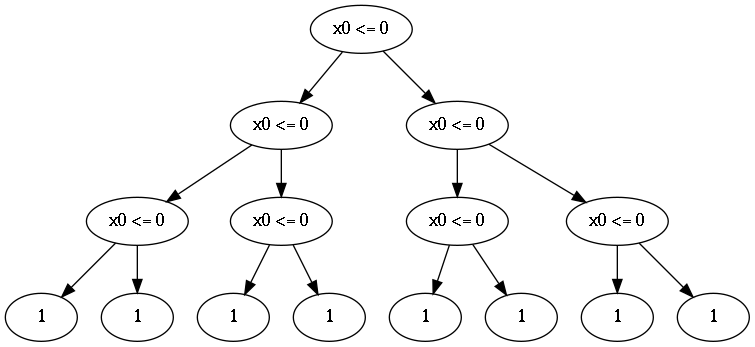

In [15]:
plot = None
if plot_tree_from_parameters != 'make_classification':
    plot = plot_tree_from_parameters(y_data_list[0][0].values, config)
plot

In [16]:
def inject_noise(y_data, noise=0.0, noise_dist='normal', seed=42):
    """
    Returns a polynomial injected with specified noise type and amount. 
    Inputs a clean polynomial array with x-data and y-data and modifies the y-data according to the noise settings.
    """
    np.random.seed(seed)
    
    #Calculate range of function values of input polynomial
    range_values_fv = np.ptp(y_data[1].values)
    
    #Selection of noise type
    #Available types: normal, uniform, A, B, C
    if noise_dist=='normal':
        noise_sample=noise*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform':
        noise_sample=noise*np.random.uniform(low=0, high=1.0,size=y_data[1].shape[0])
    elif noise_dist=='normal_range':
        #Normal distribution adjusted to function value range
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform_range':
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='flip_percentage':
        idx = np.random.choice(y_data[1].shape[0], int(y_data[1].shape[0]*noise), replace=False)
        y_data[1].iloc[idx] = (y_data[1].iloc[idx] + 1) % 2 
        return y_data
    else:
        #no noise
        noise_sample = np.zeros(y_data[1].shape[0])
                               
    noise_sample=noise_sample.reshape(-1,1)
    
    y_data[1]=y_data[1]+noise_sample
    
    return np.clip(y_data, 0, 1)

In [17]:
if noise_injected_level > 0:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    y_data_list = parallel(delayed(inject_noise)(y_data=y_data_list[i],
                                                 noise=noise_injected_level,
                                                 noise_dist=noise_injected_type, 
                                                 seed=RANDOM_SEED+i) for i in range(len(y_data_list)))


In [18]:
y_data_list[0][0].head(10)

feat0     0
feat1     0
feat2     0
feat3     0
feat4     0
feat5     0
feat6     0
split0    0
split1    0
split2    0
dtype: int64

In [19]:
y_data_list[0][0]

feat0     0
feat1     0
feat2     0
feat3     0
feat4     0
feat5     0
feat6     0
split0    0
split1    0
split2    0
split3    0
split4    0
split5    0
split6    0
lp0       0
lp1       0
lp2       0
lp3       0
lp4       0
lp5       0
lp6       0
lp7       0
dtype: int64

In [20]:
y_data_list[0][1].head(10)

,result
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


## Lambda Network Training + Weigh/Bias saving

In [21]:
#%load_ext autoreload

In [22]:
rand_index = np.random.randint(number_of_trained_lambda_nets)

#rand_tree = generate_decision_tree_from_array(y_data_list[rand_index][0].values, config)
#rand_tree.plot_tree()

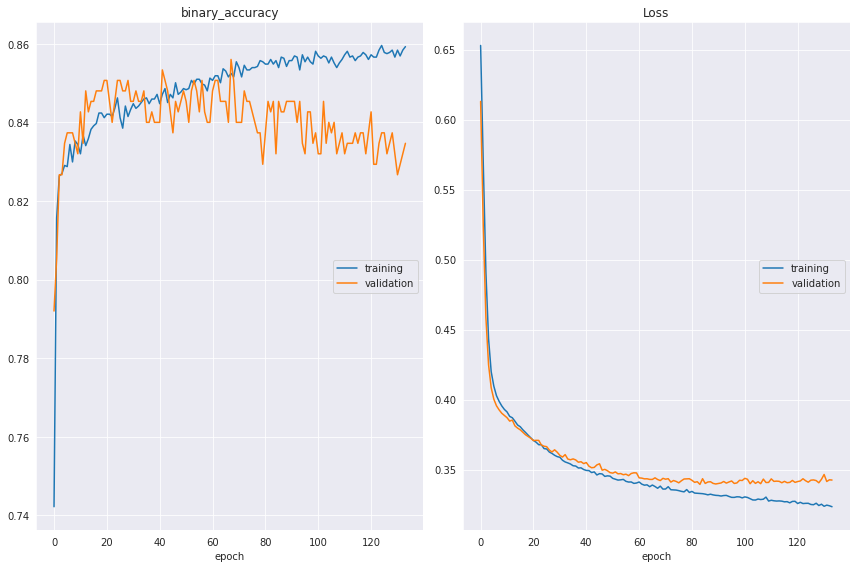

binary_accuracy
	training         	 (min:    0.742, max:    0.860, cur:    0.859)
	validation       	 (min:    0.792, max:    0.856, cur:    0.835)
Loss
	training         	 (min:    0.324, max:    0.653, cur:    0.324)
	validation       	 (min:    0.340, max:    0.613, cur:    0.343)


In [23]:
#%autoreload 2
random_network = train_lambda_net(config=config,
                                  lambda_index=rand_index, 
                                  X_data_with_function=X_data_list[rand_index], 
                                  y_data_with_function=y_data_list[rand_index], 
                                  distribution_parameter_list = distribution_parameter_list_list[rand_index][1],
                                  callbacks=[PlotLossesKerasTF()], 
                                  return_model=True,
                                  printing=False)

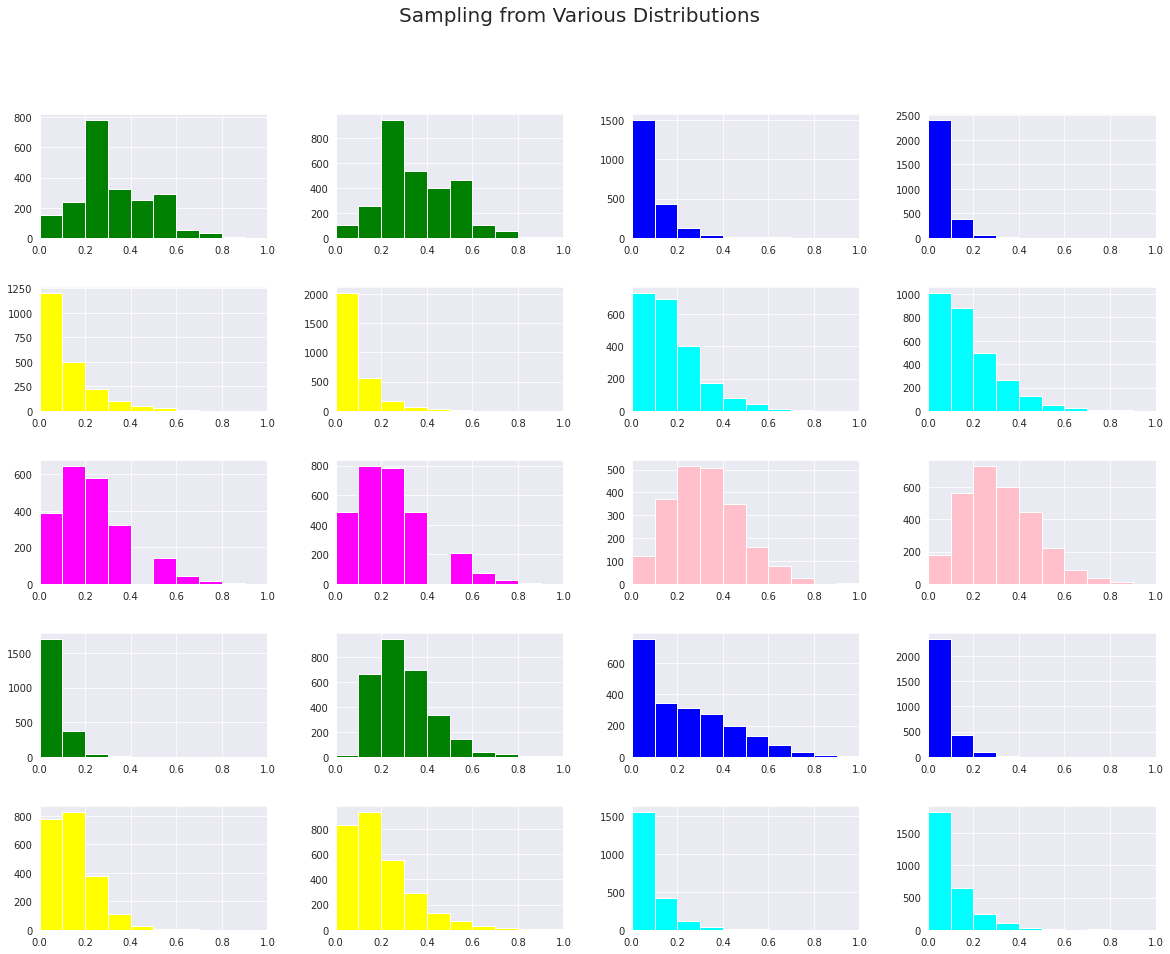

In [24]:
colors_list = ['green','blue','yellow','cyan','magenta','pink']

if config['data']['number_of_variables'] > 4:
    fig,ax = plt.subplots(nrows=np.ceil(config['data']['number_of_variables']*2/4).astype(int), ncols=4,figsize=(20,15))
else:
    fig,ax = plt.subplots(nrows=np.ceil(config['data']['number_of_variables']*2/2).astype(int), ncols=2,figsize=(20,15))

for axis_1 in ax:
    for axis_2 in axis_1:
        axis_2.set_xlim([0, 1])                          

plot_index = 0

for i in range(X_data_list[rand_index][1].values.shape[1]):
    colors = colors_list[i%6]

    x = X_data_list[rand_index][1].values[:,i][np.where(random_network['model'].predict(X_data_list[rand_index][1].values).ravel()<=0.5)]
    plt.subplot(np.ceil(config['data']['number_of_variables']*2/4).astype(int), 4,plot_index+1)
    plt.hist(x,bins=[i/10 for i in range(11)],color=colors)
    #plt.title(list(distribution_parameter.keys())[0] + ' Class 0' )
    plot_index += 1

    x = X_data_list[rand_index][1].values[:,i][np.where(random_network['model'].predict(X_data_list[rand_index][1].values).ravel()>0.5)]
    plt.subplot(np.ceil(config['data']['number_of_variables']*2/4).astype(int),4,plot_index+1)
    plt.hist(x,bins=[i/10 for i in range(11)],color=colors)
    #plt.title(list(distribution_parameter.keys())[0] + ' Class 1' )
    plot_index += 1

fig.subplots_adjust(hspace=0.4,wspace=.3) 
plt.suptitle('Sampling from Various Distributions',fontsize=20)
plt.show()

In [25]:
distribution_parameter_list_list[0][1]

[{'poisson': {'class_0': {'lam': 1.9747500921550292},
   'class_1': {'lam': 2.404191826343525},
   'samples_class_0': 861,
   'feature_weight_0': 1,
   'seed_shuffeling': 42}},
 {'weibull': {'class_0': {'a': 0.8925461868548346},
   'class_1': {'a': 1.039676735854922},
   'samples_class_0': 999,
   'feature_weight_0': 1,
   'seed_shuffeling': 42}},
 {'poisson': {'class_0': {'lam': 3.9212700816001202},
   'class_1': {'lam': 2.2571413281707864},
   'samples_class_0': 1357,
   'feature_weight_0': 1,
   'seed_shuffeling': 42}},
 {'weibull': {'class_0': {'a': 0.4683735675666395},
   'class_1': {'a': 4.759539372535517},
   'samples_class_0': 496,
   'feature_weight_0': 1,
   'seed_shuffeling': 42}},
 {'poisson': {'class_0': {'lam': 4.051666171909894},
   'class_1': {'lam': 1.2717924366845672},
   'samples_class_0': 1504,
   'feature_weight_0': 1,
   'seed_shuffeling': 42}},
 {'weibull': {'class_0': {'a': 4.383127319562459},
   'class_1': {'a': 1.0043613025907132},
   'samples_class_0': 2041,


In [26]:
#%load_ext autoreload
#%autoreload 2

In [27]:
parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky
clf_list = parallel(delayed(train_lambda_net)(config=config,
                                              lambda_index=index, 
                                              X_data_with_function=X_data, 
                                              y_data_with_function=y_data,
                                              distribution_parameter_list=distribution_parameter_list[1],
                                              return_history=True, 
                                              printing=True) for index, (X_data, y_data, distribution_parameter_list) in enumerate(zip(X_data_list, y_data_list, distribution_parameter_list_list)))  
del parallel

[Parallel(n_jobs=25)]: Using backend LokyBackend with 25 concurrent workers.
[Parallel(n_jobs=25)]: Done  78 tasks      | elapsed:  2.3min
[Parallel(n_jobs=25)]: Done 238 tasks      | elapsed:  6.3min
[Parallel(n_jobs=25)]: Done 462 tasks      | elapsed: 11.9min
[Parallel(n_jobs=25)]: Done 750 tasks      | elapsed: 18.8min
[Parallel(n_jobs=25)]: Done 1102 tasks      | elapsed: 26.9min
[Parallel(n_jobs=25)]: Done 1518 tasks      | elapsed: 37.0min
[Parallel(n_jobs=25)]: Done 1998 tasks      | elapsed: 49.3min
[Parallel(n_jobs=25)]: Done 2542 tasks      | elapsed: 62.9min
[Parallel(n_jobs=25)]: Done 3150 tasks      | elapsed: 77.2min
[Parallel(n_jobs=25)]: Done 3822 tasks      | elapsed: 92.5min
[Parallel(n_jobs=25)]: Done 4558 tasks      | elapsed: 109.9min
[Parallel(n_jobs=25)]: Done 5358 tasks      | elapsed: 130.2min
[Parallel(n_jobs=25)]: Done 6222 tasks      | elapsed: 151.0min
[Parallel(n_jobs=25)]: Done 7150 tasks      | elapsed: 173.1min
[Parallel(n_jobs=25)]: Done 8142 tasks   

In [28]:
random_network['model'].get_config()

{'name': 'sequential_1',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 10),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_2_input'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_2',
    'trainable': True,
    'batch_input_shape': (None, 10),
    'dtype': 'float32',
    'units': 128,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': 42}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_3',
    'trainable': True,
    'dtype': 'float32',
    'units': 1,
    'activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': 42}},
    'bias_i

In [29]:
random_network['model'].summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               1408      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


## Save and Plot Lambda-Model History

In [30]:
loss_list_total = []
metric_list_total = []

val_loss_list_total = []
val_metric_list_total = []

index_list = []


max_training_epochs = 0
for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    max_training_epochs = max(max_training_epochs, current_training_epochs)


for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    index = entry['index']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    
    loss_list = np.full(max_training_epochs, np.nan)
    metric_list = np.full(max_training_epochs, np.nan)
    val_loss_list = np.full(max_training_epochs, np.nan)
    val_metric_list = np.full(max_training_epochs, np.nan) 

    for i in range(current_training_epochs):  
        loss_list[i] = history[list(history.keys())[0]][i]
        metric_list[i] = history[list(history.keys())[1]][i]
        val_loss_list[i] = history[list(history.keys())[len(history.keys())//2]][i]
        val_metric_list[i] = history[list(history.keys())[len(history.keys())//2+1]][i]
    
    index_list.append([index])
    loss_list_total.append(loss_list)
    metric_list_total.append(metric_list)
    val_loss_list_total.append(val_loss_list)
    val_metric_list_total.append(val_metric_list)

loss_df = pd.DataFrame(data=np.hstack([index_list, loss_list_total]), columns=flatten_list(['index', [list(history.keys())[0] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#loss_df['index'] = loss_df['index'].astype(int)
metric_df = pd.DataFrame(data=np.hstack([index_list, metric_list_total]), columns=flatten_list(['index', [list(history.keys())[1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#metric_df['index'] = metric_df['index'].astype(int)
val_loss_df = pd.DataFrame(data=np.hstack([index_list, val_loss_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#val_loss_df['index'] = val_loss_df['index'].astype(int)
val_metric_df = pd.DataFrame(data=np.hstack([index_list, val_metric_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2+1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]])) 
#val_metric_df['index'] = val_metric_df['index'].astype(int)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [31]:
path_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[0] + '.txt'
path_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[1] + '.txt'
path_val_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2] + '.txt'
path_val_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2+1] + '.txt'

loss_df.to_csv(path_loss, index=None, sep=',')
metric_df.to_csv(path_metric, index=None, sep=',')
val_loss_df.to_csv(path_val_loss, index=None, sep=',')
val_metric_df.to_csv(path_val_metric, index=None, sep=',')


In [32]:
loss_df.describe()

,index,loss_epoch_1,loss_epoch_2,loss_epoch_3,loss_epoch_4,loss_epoch_5,loss_epoch_6,loss_epoch_7,loss_epoch_8,loss_epoch_9,loss_epoch_10,loss_epoch_11,loss_epoch_12,loss_epoch_13,loss_epoch_14,loss_epoch_15,loss_epoch_16,loss_epoch_17,loss_epoch_18,loss_epoch_19,loss_epoch_20,loss_epoch_21,loss_epoch_22,loss_epoch_23,loss_epoch_24,loss_epoch_25,loss_epoch_26,loss_epoch_27,loss_epoch_28,loss_epoch_29,loss_epoch_30,loss_epoch_31,loss_epoch_32,loss_epoch_33,loss_epoch_34,loss_epoch_35,loss_epoch_36,loss_epoch_37,loss_epoch_38,loss_epoch_39,loss_epoch_40,loss_epoch_41,loss_epoch_42,loss_epoch_43,loss_epoch_44,loss_epoch_45,loss_epoch_46,loss_epoch_47,loss_epoch_48,loss_epoch_49,loss_epoch_50,loss_epoch_51,loss_epoch_52,loss_epoch_53,loss_epoch_54,loss_epoch_55,loss_epoch_56,loss_epoch_57,loss_epoch_58,loss_epoch_59,loss_epoch_60,loss_epoch_61,loss_epoch_62,loss_epoch_63,loss_epoch_64,loss_epoch_65,loss_epoch_66,loss_epoch_67,loss_epoch_68,loss_epoch_69,loss_epoch_70,loss_epoch_71,loss_epoch_72,loss_epoch_73,loss_epoch_74,loss_epoch_75,loss_epoch_76,loss_epoch_77,loss_epoch_78,loss_epoch_79,loss_epoch_80,loss_epoch_81,loss_epoch_82,loss_epoch_83,loss_epoch_84,loss_epoch_85,loss_epoch_86,loss_epoch_87,loss_epoch_88,loss_epoch_89,loss_epoch_90,loss_epoch_91,loss_epoch_92,loss_epoch_93,loss_epoch_94,loss_epoch_95,loss_epoch_96,loss_epoch_97,loss_epoch_98,loss_epoch_99,...,loss_epoch_901,loss_epoch_902,loss_epoch_903,loss_epoch_904,loss_epoch_905,loss_epoch_906,loss_epoch_907,loss_epoch_908,loss_epoch_909,loss_epoch_910,loss_epoch_911,loss_epoch_912,loss_epoch_913,loss_epoch_914,loss_epoch_915,loss_epoch_916,loss_epoch_917,loss_epoch_918,loss_epoch_919,loss_epoch_920,loss_epoch_921,loss_epoch_922,loss_epoch_923,loss_epoch_924,loss_epoch_925,loss_epoch_926,loss_epoch_927,loss_epoch_928,loss_epoch_929,loss_epoch_930,loss_epoch_931,loss_epoch_932,loss_epoch_933,loss_epoch_934,loss_epoch_935,loss_epoch_936,loss_epoch_937,loss_epoch_938,loss_epoch_939,loss_epoch_940,loss_epoch_941,loss_epoch_942,loss_epoch_943,loss_epoch_944,loss_epoch_945,loss_epoch_946,loss_epoch_947,loss_epoch_948,loss_epoch_949,loss_epoch_950,loss_epoch_951,loss_epoch_952,loss_epoch_953,loss_epoch_954,loss_epoch_955,loss_epoch_956,loss_epoch_957,loss_epoch_958,loss_epoch_959,loss_epoch_960,loss_epoch_961,loss_epoch_962,loss_epoch_963,loss_epoch_964,loss_epoch_965,loss_epoch_966,loss_epoch_967,loss_epoch_968,loss_epoch_969,loss_epoch_970,loss_epoch_971,loss_epoch_972,loss_epoch_973,loss_epoch_974,loss_epoch_975,loss_epoch_976,loss_epoch_977,loss_epoch_978,loss_epoch_979,loss_epoch_980,loss_epoch_981,loss_epoch_982,loss_epoch_983,loss_epoch_984,loss_epoch_985,loss_epoch_986,loss_epoch_987,loss_epoch_988,loss_epoch_989,loss_epoch_990,loss_epoch_991,loss_epoch_992,loss_epoch_993,loss_epoch_994,loss_epoch_995,loss_epoch_996,loss_epoch_997,loss_epoch_998,loss_epoch_999,loss_epoch_1000
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,9999.000,9999.000,9999.000,9993.000,9988.000,9981.000,9976.000,9966.000,9957.000,9947.000,9941.000,9938.000,9928.000,9921.000,9915.000,9903.000,9892.000,9886.000,9876.000,9868.000,9855.000,9846.000,9835.000,9827.000,9809.000,9786.000,9775.000,9754.000,9751.000,9726.000,9709.000,9686.000,9675.000,9649.000,9631.000,9607.000,9590.000,9569.000,9546.000,9527.000,9502.000,9477.000,9452.000,9427.000,9409.000,9364.000,9339.000,...,6.000,6.000,6.000,6.000,6.000,6.000,6.000,6.000,6.000,6.000,6.000,6.000,6.000,6.000,6.000,6.000,6.000,6.000,6.000,6.000,6.000,6.000,6.000,6.000,6.00

In [33]:
val_loss_df.describe()

,index,val_loss_epoch_1,val_loss_epoch_2,val_loss_epoch_3,val_loss_epoch_4,val_loss_epoch_5,val_loss_epoch_6,val_loss_epoch_7,val_loss_epoch_8,val_loss_epoch_9,val_loss_epoch_10,val_loss_epoch_11,val_loss_epoch_12,val_loss_epoch_13,val_loss_epoch_14,val_loss_epoch_15,val_loss_epoch_16,val_loss_epoch_17,val_loss_epoch_18,val_loss_epoch_19,val_loss_epoch_20,val_loss_epoch_21,val_loss_epoch_22,val_loss_epoch_23,val_loss_epoch_24,val_loss_epoch_25,val_loss_epoch_26,val_loss_epoch_27,val_loss_epoch_28,val_loss_epoch_29,val_loss_epoch_30,val_loss_epoch_31,val_loss_epoch_32,val_loss_epoch_33,val_loss_epoch_34,val_loss_epoch_35,val_loss_epoch_36,val_loss_epoch_37,val_loss_epoch_38,val_loss_epoch_39,val_loss_epoch_40,val_loss_epoch_41,val_loss_epoch_42,val_loss_epoch_43,val_loss_epoch_44,val_loss_epoch_45,val_loss_epoch_46,val_loss_epoch_47,val_loss_epoch_48,val_loss_epoch_49,val_loss_epoch_50,val_loss_epoch_51,val_loss_epoch_52,val_loss_epoch_53,val_loss_epoch_54,val_loss_epoch_55,val_loss_epoch_56,val_loss_epoch_57,val_loss_epoch_58,val_loss_epoch_59,val_loss_epoch_60,val_loss_epoch_61,val_loss_epoch_62,val_loss_epoch_63,val_loss_epoch_64,val_loss_epoch_65,val_loss_epoch_66,val_loss_epoch_67,val_loss_epoch_68,val_loss_epoch_69,val_loss_epoch_70,val_loss_epoch_71,val_loss_epoch_72,val_loss_epoch_73,val_loss_epoch_74,val_loss_epoch_75,val_loss_epoch_76,val_loss_epoch_77,val_loss_epoch_78,val_loss_epoch_79,val_loss_epoch_80,val_loss_epoch_81,val_loss_epoch_82,val_loss_epoch_83,val_loss_epoch_84,val_loss_epoch_85,val_loss_epoch_86,val_loss_epoch_87,val_loss_epoch_88,val_loss_epoch_89,val_loss_epoch_90,val_loss_epoch_91,val_loss_epoch_92,val_loss_epoch_93,val_loss_epoch_94,val_loss_epoch_95,val_loss_epoch_96,val_loss_epoch_97,val_loss_epoch_98,val_loss_epoch_99,...,val_loss_epoch_901,val_loss_epoch_902,val_loss_epoch_903,val_loss_epoch_904,val_loss_epoch_905,val_loss_epoch_906,val_loss_epoch_907,val_loss_epoch_908,val_loss_epoch_909,val_loss_epoch_910,val_loss_epoch_911,val_loss_epoch_912,val_loss_epoch_913,val_loss_epoch_914,val_loss_epoch_915,val_loss_epoch_916,val_loss_epoch_917,val_loss_epoch_918,val_loss_epoch_919,val_loss_epoch_920,val_loss_epoch_921,val_loss_epoch_922,val_loss_epoch_923,val_loss_epoch_924,val_loss_epoch_925,val_loss_epoch_926,val_loss_epoch_927,val_loss_epoch_928,val_loss_epoch_929,val_loss_epoch_930,val_loss_epoch_931,val_loss_epoch_932,val_loss_epoch_933,val_loss_epoch_934,val_loss_epoch_935,val_loss_epoch_936,val_loss_epoch_937,val_loss_epoch_938,val_loss_epoch_939,val_loss_epoch_940,val_loss_epoch_941,val_loss_epoch_942,val_loss_epoch_943,val_loss_epoch_944,val_loss_epoch_945,val_loss_epoch_946,val_loss_epoch_947,val_loss_epoch_948,val_loss_epoch_949,val_loss_epoch_950,val_loss_epoch_951,val_loss_epoch_952,val_loss_epoch_953,val_loss_epoch_954,val_loss_epoch_955,val_loss_epoch_956,val_loss_epoch_957,val_loss_epoch_958,val_loss_epoch_959,val_loss_epoch_960,val_loss_epoch_961,val_loss_epoch_962,val_loss_epoch_963,val_loss_epoch_964,val_loss_epoch_965,val_loss_epoch_966,val_loss_epoch_967,val_loss_epoch_968,val_loss_epoch_969,val_loss_epoch_970,val_loss_epoch_971,val_loss_epoch_972,val_loss_epoch_973,val_loss_epoch_974,val_loss_epoch_975,val_loss_epoch_976,val_loss_epoch_977,val_loss_epoch_978,val_loss_epoch_979,val_loss_epoch_980,val_loss_epoch_981,val_loss_epoch_982,val_loss_epoch_983,val_loss_epoch_984,val_loss_epoch_985,val_loss_epoch_986,val_loss_epoch_987,val_loss_epoch_988,val_loss_epoch_989,val_loss_epoch_990,val_loss_epoch_991,val_loss_epoch_992,val_loss_epoch_993,val_loss_epoch_994,val_loss_epoch_995,val_loss_epoch_996,val_loss_epoch_997,val_loss_epoch_998,val_loss_epoch_999,val_loss_epoch_1000
count,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000

In [34]:
metric_df.describe()

,index,binary_accuracy_epoch_1,binary_accuracy_epoch_2,binary_accuracy_epoch_3,binary_accuracy_epoch_4,binary_accuracy_epoch_5,binary_accuracy_epoch_6,binary_accuracy_epoch_7,binary_accuracy_epoch_8,binary_accuracy_epoch_9,binary_accuracy_epoch_10,binary_accuracy_epoch_11,binary_accuracy_epoch_12,binary_accuracy_epoch_13,binary_accuracy_epoch_14,binary_accuracy_epoch_15,binary_accuracy_epoch_16,binary_accuracy_epoch_17,binary_accuracy_epoch_18,binary_accuracy_epoch_19,binary_accuracy_epoch_20,binary_accuracy_epoch_21,binary_accuracy_epoch_22,binary_accuracy_epoch_23,binary_accuracy_epoch_24,binary_accuracy_epoch_25,binary_accuracy_epoch_26,binary_accuracy_epoch_27,binary_accuracy_epoch_28,binary_accuracy_epoch_29,binary_accuracy_epoch_30,binary_accuracy_epoch_31,binary_accuracy_epoch_32,binary_accuracy_epoch_33,binary_accuracy_epoch_34,binary_accuracy_epoch_35,binary_accuracy_epoch_36,binary_accuracy_epoch_37,binary_accuracy_epoch_38,binary_accuracy_epoch_39,binary_accuracy_epoch_40,binary_accuracy_epoch_41,binary_accuracy_epoch_42,binary_accuracy_epoch_43,binary_accuracy_epoch_44,binary_accuracy_epoch_45,binary_accuracy_epoch_46,binary_accuracy_epoch_47,binary_accuracy_epoch_48,binary_accuracy_epoch_49,binary_accuracy_epoch_50,binary_accuracy_epoch_51,binary_accuracy_epoch_52,binary_accuracy_epoch_53,binary_accuracy_epoch_54,binary_accuracy_epoch_55,binary_accuracy_epoch_56,binary_accuracy_epoch_57,binary_accuracy_epoch_58,binary_accuracy_epoch_59,binary_accuracy_epoch_60,binary_accuracy_epoch_61,binary_accuracy_epoch_62,binary_accuracy_epoch_63,binary_accuracy_epoch_64,binary_accuracy_epoch_65,binary_accuracy_epoch_66,binary_accuracy_epoch_67,binary_accuracy_epoch_68,binary_accuracy_epoch_69,binary_accuracy_epoch_70,binary_accuracy_epoch_71,binary_accuracy_epoch_72,binary_accuracy_epoch_73,binary_accuracy_epoch_74,binary_accuracy_epoch_75,binary_accuracy_epoch_76,binary_accuracy_epoch_77,binary_accuracy_epoch_78,binary_accuracy_epoch_79,binary_accuracy_epoch_80,binary_accuracy_epoch_81,binary_accuracy_epoch_82,binary_accuracy_epoch_83,binary_accuracy_epoch_84,binary_accuracy_epoch_85,binary_accuracy_epoch_86,binary_accuracy_epoch_87,binary_accuracy_epoch_88,binary_accuracy_epoch_89,binary_accuracy_epoch_90,binary_accuracy_epoch_91,binary_accuracy_epoch_92,binary_accuracy_epoch_93,binary_accuracy_epoch_94,binary_accuracy_epoch_95,binary_accuracy_epoch_96,binary_accuracy_epoch_97,binary_accuracy_epoch_98,binary_accuracy_epoch_99,...,binary_accuracy_epoch_901,binary_accuracy_epoch_902,binary_accuracy_epoch_903,binary_accuracy_epoch_904,binary_accuracy_epoch_905,binary_accuracy_epoch_906,binary_accuracy_epoch_907,binary_accuracy_epoch_908,binary_accuracy_epoch_909,binary_accuracy_epoch_910,binary_accuracy_epoch_911,binary_accuracy_epoch_912,binary_accuracy_epoch_913,binary_accuracy_epoch_914,binary_accuracy_epoch_915,binary_accuracy_epoch_916,binary_accuracy_epoch_917,binary_accuracy_epoch_918,binary_accuracy_epoch_919,binary_accuracy_epoch_920,binary_accuracy_epoch_921,binary_accuracy_epoch_922,binary_accuracy_epoch_923,binary_accuracy_epoch_924,binary_accuracy_epoch_925,binary_accuracy_epoch_926,binary_accuracy_epoch_927,binary_accuracy_epoch_928,binary_accuracy_epoch_929,binary_accuracy_epoch_930,binary_accuracy_epoch_931,binary_accuracy_epoch_932,binary_accuracy_epoch_933,binary_accuracy_epoch_934,binary_accuracy_epoch_935,binary_accuracy_epoch_936,binary_accuracy_epoch_937,binary_accuracy_epoch_938,binary_accuracy_epoch_939,binary_accuracy_epoch_940,binary_accuracy_epoch_941,binary_accuracy_epoch_942,binary_accuracy_epoch_943,binary_accuracy_epoch_944,binary_accuracy_epoch_945,binary_accuracy_epoch_946,binary_accuracy_epoch_947,binary_accuracy_epoch_948,binary_accuracy_epoch_949,binary_accuracy_epoch_950,binary_accuracy_epoch_951,binary_accuracy_epoch_952,binary_accuracy_epoch_953,binary_accuracy_epoch_954,binary_accuracy_epoch_955,binary_accuracy_epoch_956,binary_accuracy_epoch_957,binary_accuracy_epoch_958,binary_accuracy

In [35]:
val_metric_df.describe()

,index,val_binary_accuracy_epoch_1,val_binary_accuracy_epoch_2,val_binary_accuracy_epoch_3,val_binary_accuracy_epoch_4,val_binary_accuracy_epoch_5,val_binary_accuracy_epoch_6,val_binary_accuracy_epoch_7,val_binary_accuracy_epoch_8,val_binary_accuracy_epoch_9,val_binary_accuracy_epoch_10,val_binary_accuracy_epoch_11,val_binary_accuracy_epoch_12,val_binary_accuracy_epoch_13,val_binary_accuracy_epoch_14,val_binary_accuracy_epoch_15,val_binary_accuracy_epoch_16,val_binary_accuracy_epoch_17,val_binary_accuracy_epoch_18,val_binary_accuracy_epoch_19,val_binary_accuracy_epoch_20,val_binary_accuracy_epoch_21,val_binary_accuracy_epoch_22,val_binary_accuracy_epoch_23,val_binary_accuracy_epoch_24,val_binary_accuracy_epoch_25,val_binary_accuracy_epoch_26,val_binary_accuracy_epoch_27,val_binary_accuracy_epoch_28,val_binary_accuracy_epoch_29,val_binary_accuracy_epoch_30,val_binary_accuracy_epoch_31,val_binary_accuracy_epoch_32,val_binary_accuracy_epoch_33,val_binary_accuracy_epoch_34,val_binary_accuracy_epoch_35,val_binary_accuracy_epoch_36,val_binary_accuracy_epoch_37,val_binary_accuracy_epoch_38,val_binary_accuracy_epoch_39,val_binary_accuracy_epoch_40,val_binary_accuracy_epoch_41,val_binary_accuracy_epoch_42,val_binary_accuracy_epoch_43,val_binary_accuracy_epoch_44,val_binary_accuracy_epoch_45,val_binary_accuracy_epoch_46,val_binary_accuracy_epoch_47,val_binary_accuracy_epoch_48,val_binary_accuracy_epoch_49,val_binary_accuracy_epoch_50,val_binary_accuracy_epoch_51,val_binary_accuracy_epoch_52,val_binary_accuracy_epoch_53,val_binary_accuracy_epoch_54,val_binary_accuracy_epoch_55,val_binary_accuracy_epoch_56,val_binary_accuracy_epoch_57,val_binary_accuracy_epoch_58,val_binary_accuracy_epoch_59,val_binary_accuracy_epoch_60,val_binary_accuracy_epoch_61,val_binary_accuracy_epoch_62,val_binary_accuracy_epoch_63,val_binary_accuracy_epoch_64,val_binary_accuracy_epoch_65,val_binary_accuracy_epoch_66,val_binary_accuracy_epoch_67,val_binary_accuracy_epoch_68,val_binary_accuracy_epoch_69,val_binary_accuracy_epoch_70,val_binary_accuracy_epoch_71,val_binary_accuracy_epoch_72,val_binary_accuracy_epoch_73,val_binary_accuracy_epoch_74,val_binary_accuracy_epoch_75,val_binary_accuracy_epoch_76,val_binary_accuracy_epoch_77,val_binary_accuracy_epoch_78,val_binary_accuracy_epoch_79,val_binary_accuracy_epoch_80,val_binary_accuracy_epoch_81,val_binary_accuracy_epoch_82,val_binary_accuracy_epoch_83,val_binary_accuracy_epoch_84,val_binary_accuracy_epoch_85,val_binary_accuracy_epoch_86,val_binary_accuracy_epoch_87,val_binary_accuracy_epoch_88,val_binary_accuracy_epoch_89,val_binary_accuracy_epoch_90,val_binary_accuracy_epoch_91,val_binary_accuracy_epoch_92,val_binary_accuracy_epoch_93,val_binary_accuracy_epoch_94,val_binary_accuracy_epoch_95,val_binary_accuracy_epoch_96,val_binary_accuracy_epoch_97,val_binary_accuracy_epoch_98,val_binary_accuracy_epoch_99,...,val_binary_accuracy_epoch_901,val_binary_accuracy_epoch_902,val_binary_accuracy_epoch_903,val_binary_accuracy_epoch_904,val_binary_accuracy_epoch_905,val_binary_accuracy_epoch_906,val_binary_accuracy_epoch_907,val_binary_accuracy_epoch_908,val_binary_accuracy_epoch_909,val_binary_accuracy_epoch_910,val_binary_accuracy_epoch_911,val_binary_accuracy_epoch_912,val_binary_accuracy_epoch_913,val_binary_accuracy_epoch_914,val_binary_accuracy_epoch_915,val_binary_accuracy_epoch_916,val_binary_accuracy_epoch_917,val_binary_accuracy_epoch_918,val_binary_accuracy_epoch_919,val_binary_accuracy_epoch_920,val_binary_accuracy_epoch_921,val_binary_accuracy_epoch_922,val_binary_accuracy_epoch_923,val_binary_accuracy_epoch_924,val_binary_accuracy_epoch_925,val_binary_accuracy_epoch_926,val_binary_accuracy_epoch_927,val_binary_accuracy_epoch_928,val_binary_accuracy_epoch_929,val_binary_accuracy_epoch_930,val_binary_accuracy_epoch_931,val_binary_accuracy_epoch_932,val_binary_accuracy_epoch_933,val_binary_accuracy_epoch_934,val_binary_accuracy_epoch_935,val_binary_accuracy_epoch_936,val_binary_accuracy_epoch_937,val_binary_accura

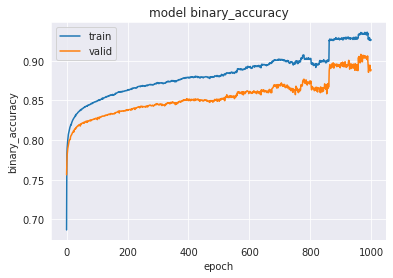

In [36]:
# summarize history for metric
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[1] + '.png'

adjustment_threshold_metric = 10#100
    
metric_df_adjusted = metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    metric_df_adjusted[metric_df_adjusted.columns] = np.where(metric_df_adjusted[metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, metric_df_adjusted[metric_df_adjusted.columns])
    
val_metric_df_adjusted = val_metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    val_metric_df_adjusted[val_metric_df_adjusted.columns] = np.where(val_metric_df_adjusted[val_metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, val_metric_df_adjusted[val_metric_df_adjusted.columns])

    
plt.plot(metric_df_adjusted.describe().loc['mean'].values)
plt.plot(val_metric_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[1])
plt.ylabel(list(history.keys())[1])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()


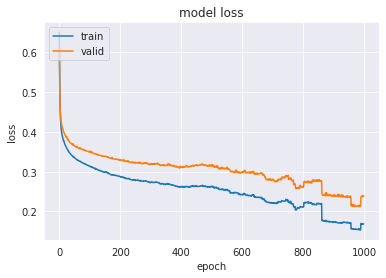

In [37]:
# summarize history for loss
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[0] + '.png'

adjustment_threshold_loss = 0#10000
    
loss_df_adjusted = loss_df.copy(deep=True).iloc[:,1:]

if adjustment_threshold_loss > 0:
    loss_df_adjusted[loss_df_adjusted.columns] = np.where(loss_df_adjusted[loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, loss_df_adjusted[loss_df_adjusted.columns])
    
val_loss_df_adjusted = val_loss_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_loss > 0:
    val_loss_df_adjusted[val_loss_df_adjusted.columns] = np.where(val_loss_df_adjusted[val_loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, val_loss_df_adjusted[val_loss_df_adjusted.columns])

    
plt.plot(loss_df_adjusted.describe().loc['mean'].values)
plt.plot(val_loss_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[0])
plt.ylabel(list(history.keys())[0])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()


In [38]:
if use_gpu:
    from numba import cuda 
    device = cuda.get_current_device()
    device.reset()